In [4]:
import matplotlib.pyplot as plt
import numpy as np
import shap
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import resnet34, resnet50
from tqdm.notebook import tqdm

from src.config import settings
from src.datasets.pcam.datamodule import PCAMDataModule
from src.engines.system import PCAMSystem

In [5]:
# Select device.
torch.cuda.empty_cache()

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
print(f"Using device: {device}")

# Load model.
# model = resnet34(weights="IMAGENET1K_V1")
#model = resnet34()
model = resnet50()
model.to(device)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)

model.eval()

MODEL_PATH = "./models/ResNet50/best-loss-model-epoch=00-val_loss=0.83.ckpt"
#MODEL_PATH = "./models/checkpoints/best-loss-model-epoch=01-val_loss=0.30.ckpt"
system = PCAMSystem.load_from_checkpoint(
        checkpoint_path=MODEL_PATH,
        model=model, map_location=device)

Using device: cpu


In [6]:
datamodule = PCAMDataModule(
    data_dir=settings.processed_data_dir / "pcam", transforms=transforms.Compose([transforms.ToTensor()]), batch_size=8
)
datamodule.setup(stage="predict")
test_dataloader = datamodule.test_dataloader()

images_list = []
labels_list = []
for batch in test_dataloader:
    images_list.append(batch[0])
    labels_list.append(batch[1])
    break

images = torch.cat(images_list)
images = images.to(device)
images.requires_grad = True
labels = torch.cat(labels_list)
labels = labels.to(device)
model = model.to(device)

examples = [f"Image #{x}" for x in range(images.shape[0])]

print(f"{images.shape=}")
print(f"{labels.shape=}")

images.shape=torch.Size([8, 3, 96, 96])
labels.shape=torch.Size([8])


In [7]:
def predict_labels(
    imgs_preprocessed: torch.Tensor,
    model: nn.Module,
    requires_grad: bool = True,
) -> torch.Tensor:
    """Predict the an image's label using the given model.

    Args:
        imgs_preprocessed (torch.Tensor): Pre-processed images.
            Shape: [batch_size, channels, height, width]
        model (nn.Module): Model to use.
        requires_grad (bool, optional): Whether to calculate gradients.
            Defaults to True.

    Returns:
        probs (torch.Tensor): Probability for each possible label.
            Shape: [batch_size, num_classes]
    """
    # Calculate logits and convert to probabilities.
    if requires_grad:
        logits = model(imgs_preprocessed)  # batch_size x num_classes
    else:
        with torch.no_grad():
            logits = model(imgs_preprocessed)

    # We want to pretend like we have 2 output classes, so we need to do sigmoid and after that set the second class to 1 - sigmoid.
    return torch.cat((1-F.sigmoid(logits), F.sigmoid(logits)), dim=1)  # convert to probabilities
    #return F.softmax(logits, dim=1)  # convert to probabilities


# Test the predict_label function.
probs = predict_labels(images, model)
print(f"{probs.shape=}")
top5_probs, top5_labels_pred = torch.topk(probs, k=2, dim=1)
acc = 0
for (i, ex), label in zip(enumerate(examples), labels):
    print(f"{ex}:")
    print(f"    {top5_probs[i]=}")
    print(f"    {top5_labels_pred[i]=}")
    print(f"    {label=}")
    acc += top5_labels_pred[i][0] == label

acc = acc / images.shape[0]
print(f"{acc=}")


probs.shape=torch.Size([8, 2])
Image #0:
    top5_probs[i]=tensor([9.9982e-01, 1.7673e-04], grad_fn=<SelectBackward0>)
    top5_labels_pred[i]=tensor([1, 0])
    label=tensor(0.)
Image #1:
    top5_probs[i]=tensor([9.9966e-01, 3.4237e-04], grad_fn=<SelectBackward0>)
    top5_labels_pred[i]=tensor([1, 0])
    label=tensor(1.)
Image #2:
    top5_probs[i]=tensor([9.9963e-01, 3.7181e-04], grad_fn=<SelectBackward0>)
    top5_labels_pred[i]=tensor([1, 0])
    label=tensor(0.)
Image #3:
    top5_probs[i]=tensor([0.9983, 0.0017], grad_fn=<SelectBackward0>)
    top5_labels_pred[i]=tensor([1, 0])
    label=tensor(1.)
Image #4:
    top5_probs[i]=tensor([9.9910e-01, 9.0420e-04], grad_fn=<SelectBackward0>)
    top5_labels_pred[i]=tensor([1, 0])
    label=tensor(1.)
Image #5:
    top5_probs[i]=tensor([0.9972, 0.0028], grad_fn=<SelectBackward0>)
    top5_labels_pred[i]=tensor([1, 0])
    label=tensor(0.)
Image #6:
    top5_probs[i]=tensor([0.9975, 0.0025], grad_fn=<SelectBackward0>)
    top5_labels_p

In [8]:
def calc_gradients_saliency_map(
    imgs_preprocessed: torch.Tensor,
    model: nn.Module,
    requires_grad: bool = True,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Calculate the gradients using Saliency Mapping.

    Args:
        imgs_preprocessed (torch.Tensor): Batch of pre-processed images.
            Shape: [batch_size, channels, height, width]
        model (nn.Module): Model to use.
        requires_grad (bool, optional): Whether to calculate gradients.
            Defaults to True.

    Returns:
        gradients (torch.Tensor): Gradients of the model's output w.r.t. the
            input images.
            Shape: [batch_size, height, width, channels]
        labels_pred (torch.Tensor): Predicted labels.
            Shape: [batch_size]
    """
    # Predict labels.
    probs = predict_labels(imgs_preprocessed, model, requires_grad)

    # Get the indices of the target labels.
    labels_pred = torch.argmax(probs, dim=1)

    # Calculate gradients for each image in the batch.
    print("Calculating gradients...")
    gradients = []
    for i in tqdm(range(len(labels_pred)), unit="image"):
        model.zero_grad()
        probs[i, labels_pred[i]].backward(retain_graph=True)
        gradient = imgs_preprocessed.grad[i].detach()
        gradients.append(gradient)
    gradients = torch.stack(gradients)
    gradients = gradients.permute(0, 2, 3, 1)  # b x c x h x w -> b x h x w x c

    return gradients, labels_pred


# Test the calc_gradients_saliency_map function.
gradients, labels_pred = calc_gradients_saliency_map(images, model)
print(f"{gradients.shape=}")
print(f"{labels_pred.shape=}")


Calculating gradients...


  0%|          | 0/8 [00:00<?, ?image/s]

gradients.shape=torch.Size([8, 96, 96, 3])
labels_pred.shape=torch.Size([8])


In [9]:
gradients.cpu()

tensor([[[[ 4.7769e-07,  4.0723e-07, -1.8668e-08],
          [ 6.5756e-07,  1.8899e-08, -4.5580e-07],
          [ 8.2978e-07, -8.7016e-07,  2.5758e-07],
          ...,
          [-3.8359e-07,  1.5820e-08,  1.4883e-07],
          [-3.6624e-07,  8.2919e-08,  2.5231e-07],
          [ 5.7943e-07, -1.9282e-07, -5.9210e-07]],

         [[ 6.6769e-08, -3.5233e-07,  4.0121e-07],
          [ 1.3143e-06,  2.8650e-07,  9.5239e-07],
          [ 6.0860e-07, -5.6711e-07, -2.8191e-07],
          ...,
          [ 1.3683e-07,  1.5056e-07,  6.9366e-07],
          [-2.5250e-07,  8.6500e-08,  1.0543e-07],
          [ 4.3621e-09, -1.5158e-07, -9.0963e-08]],

         [[-1.3330e-06,  2.0510e-07, -5.3445e-07],
          [ 6.8229e-08, -4.6999e-07,  3.5579e-07],
          [ 1.7611e-07, -5.6868e-07,  7.6895e-07],
          ...,
          [ 3.0672e-07, -2.2802e-07, -4.4019e-07],
          [-2.0844e-09,  4.3069e-07, -2.1188e-08],
          [-4.1321e-08, -1.0242e-07, -1.4696e-07]],

         ...,

         [[ 1.41

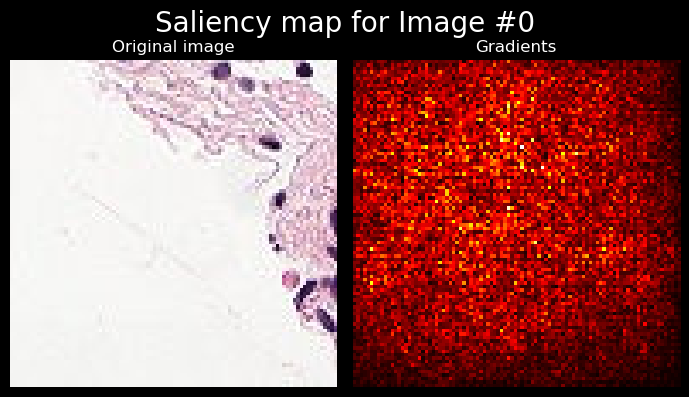

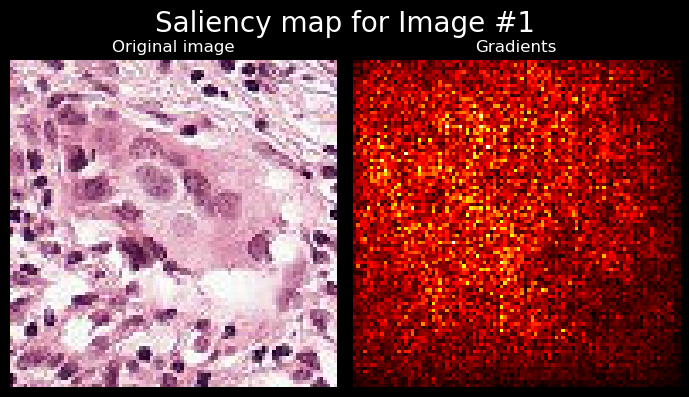

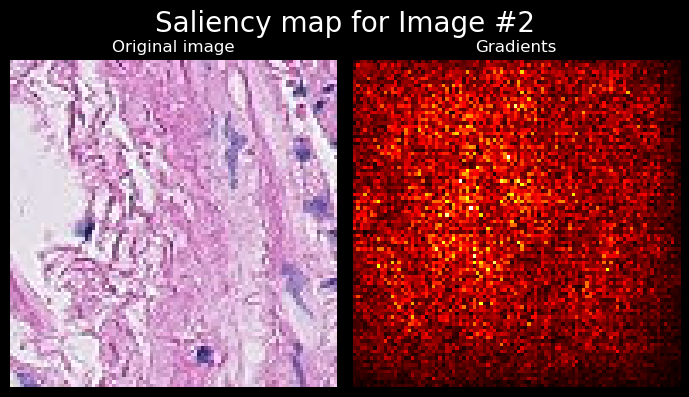

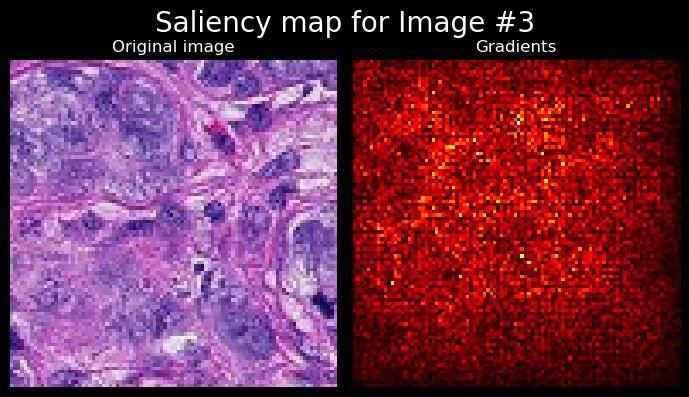

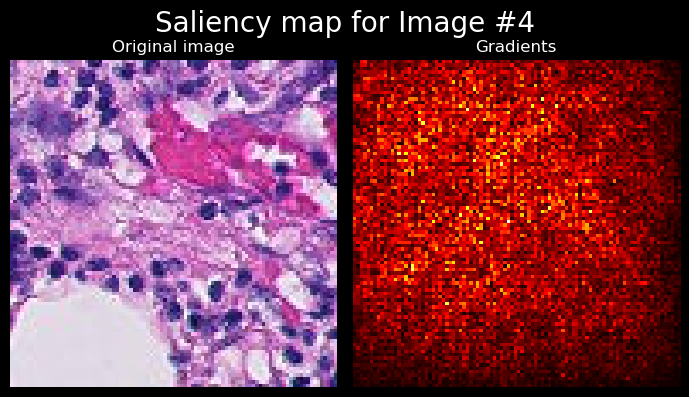

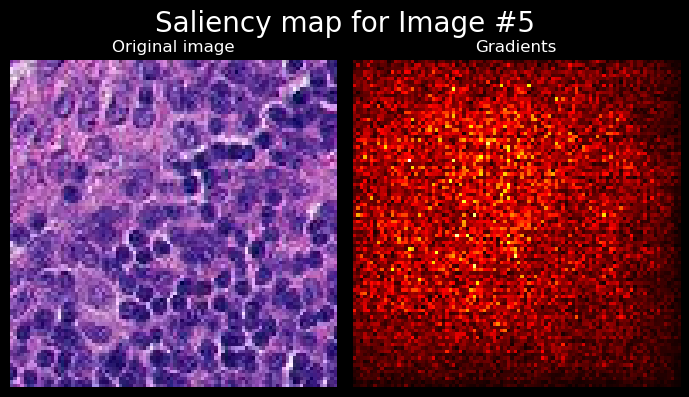

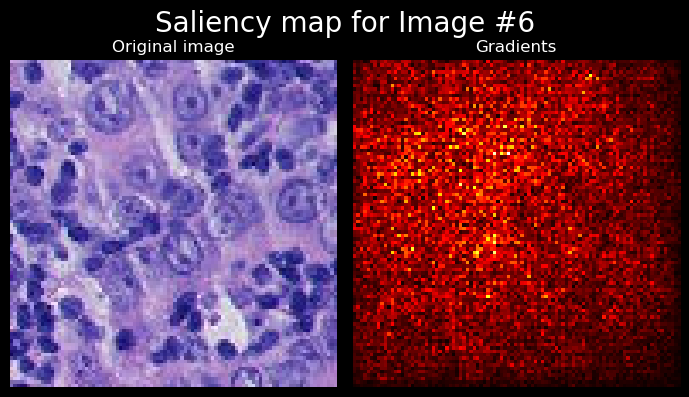

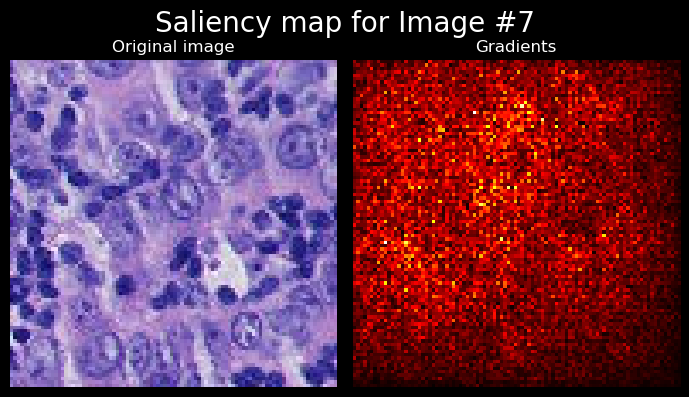

In [10]:
def plot_gradients(
    img: np.ndarray | torch.Tensor, gradient: torch.Tensor, title: str
) -> None:
    """Plot the gradients of the image.

    Args:
        img (np.ndarray | torch.Tensor): Image.
            Shape: [channels, height, width]
        gradients (torch.Tensor): Gradients of the model's output w.r.t. the
            input image.
            Shape: [height, width, channels]
        title (str): Title of the plot.
    """
    img = np.transpose(img.cpu().detach(), (1, 2, 0))  # c x h x w -> h x w x c

    # Take the maximum value over the channels.
    saliency = torch.max(torch.abs(gradient.cpu()), dim=-1).values

    # Visualize the image and the saliency map.
    fig, axs = plt.subplots(1, 2, figsize=(7, 4))
    axs[0].imshow(img)
    axs[0].axis("off")
    axs[0].set_title("Original image")
    axs[1].imshow(saliency, cmap="hot")
    axs[1].axis("off")
    axs[1].set_title("Gradients")
    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()


# Test the plot_gradients function.
for ex, img, gradient in zip(examples, images, gradients):
    plot_gradients(img, gradient, title=f"Saliency map for {ex}")


In [11]:
def calc_gradients_integrated_gradients(
    imgs_preprocessed: torch.Tensor,
    baselines_preprocessed: torch.Tensor,
    model: nn.Module,
    steps: int = 20,
    requires_grad: bool = True,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Calculate the gradients using Integrated Gradients.

    Args:
        imgs_preprocessed (torch.Tensor): Batch of pre-processed images.
            Shape: [batch_size, channels, height, width]
        baselines_preprocessed (torch.Tensor): Batch of pre-processed
            baseline images.
            Shape: [batch_size, channels, height, width]
        model (nn.Module): The model.
        steps (int, optional): Number of steps between the baseline and the
            input. Defaults to 20.
        requires_grad (bool, optional): Whether to calculate gradients.
            Defaults to True.

    Returns:
        gradients (torch.Tensor): Integrated gradients of the model's output
            w.r.t. the input images.
            Shape: [batch_size, height, width, channels]
        labels_pred (torch.Tensor): Predicted labels.
            Shape: [batch_size]
    """
    # Predict labels.
    probs = predict_labels(imgs_preprocessed, model, requires_grad)

    # Get the indices of the target labels.
    labels_pred = torch.argmax(probs, dim=1)

    # Calculate gradients for each image in the batch.
    gradients = torch.zeros_like(imgs_preprocessed)
    diffs_preprocessed = (
        imgs_preprocessed.detach() - baselines_preprocessed
    ) / steps
    partial_imgs_preprocessed = baselines_preprocessed.clone()
    for _ in tqdm(range(steps), unit="step"):
        partial_imgs_preprocessed += diffs_preprocessed
        partial_imgs_preprocessed_cp = (
            partial_imgs_preprocessed.clone().detach().requires_grad_(True)
        )  # make tensor a leaf node
        partial_probs = predict_labels(
            partial_imgs_preprocessed_cp, model, requires_grad
        )
        for i in range(len(labels_pred)):
            model.zero_grad()
            partial_probs[i, labels_pred[i]].backward(retain_graph=True)
            gradient = partial_imgs_preprocessed_cp.grad[i].detach()
            gradients[i] += gradient

    # Average the gradients across the steps and multiply by the diffs.
    # This line is sort of a "hack": it performs the averaging operation and
    # the multiplication by (x - x') in one step. It works because the
    # gradients were already summed across the steps, and the diffs were
    # already divided by `steps` when they were initialized.
    gradients *= diffs_preprocessed

    # Permute the dimensions to match the input images.
    gradients = gradients.permute(0, 2, 3, 1)  # b x c x h x w -> b x h x w x c

    return gradients, labels_pred


In [12]:
def integrated_gradients_baseline_black(
    imgs_preprocessed: torch.Tensor,
    model: nn.Module,
    steps: int = 20,
    requires_grad: bool = True,
) -> tuple[torch.Tensor, torch.Tensor]:
    """Calculate the gradients using IG with a black image baseline.

    Args:
        imgs_preprocessed (torch.Tensor): Batch of pre-processed images.
            Shape: [batch_size, channels, height, width]
        model (nn.Module): The model.
        steps (int, optional): Number of steps between the baseline and the
            input. Defaults to 20.
        requires_grad (bool, optional): Whether to calculate gradients.
            Defaults to True.

    Returns:
        gradients (torch.Tensor): Integrated gradients of the model's output
            w.r.t. the input images.
            Shape: [batch_size, height, width, channels]
        labels_pred (torch.Tensor): Predicted labels.
            Shape: [batch_size]
    """
    # Create the baseline images.
    baselines_preprocessed = torch.zeros_like(imgs_preprocessed)

    return calc_gradients_integrated_gradients(
        imgs_preprocessed, baselines_preprocessed, model, steps, requires_grad
    )


# Test the calc_gradients_integrated_gradients function.
gradients_black, labels_pred = integrated_gradients_baseline_black(
    images, model
)
print(f"{gradients_black.shape=}")

  0%|          | 0/20 [00:00<?, ?step/s]

gradients_black.shape=torch.Size([8, 96, 96, 3])


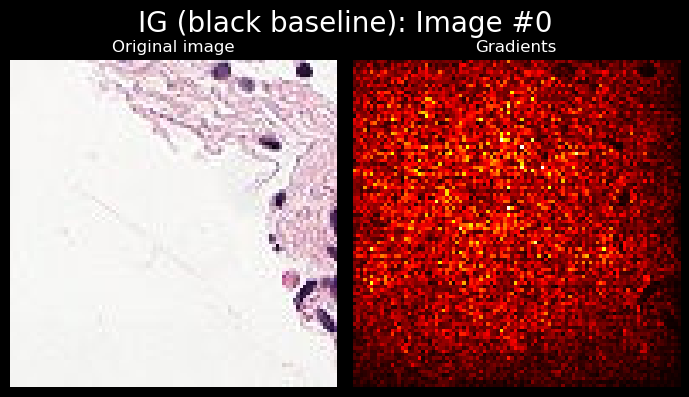

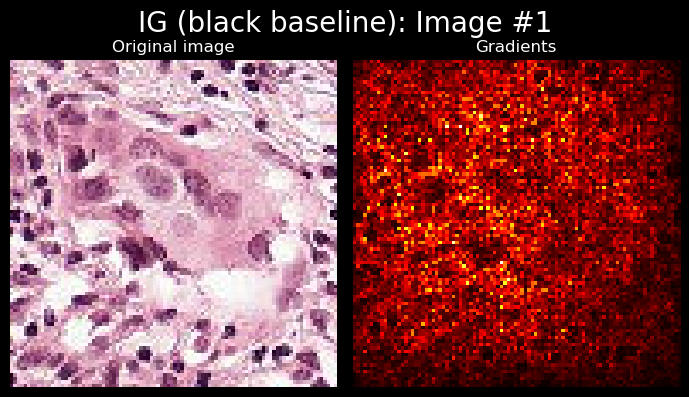

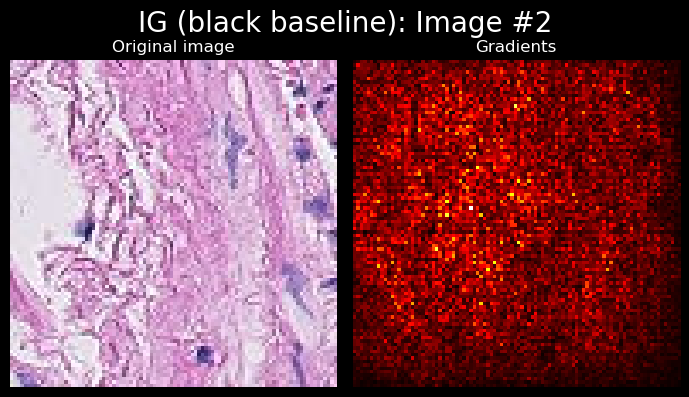

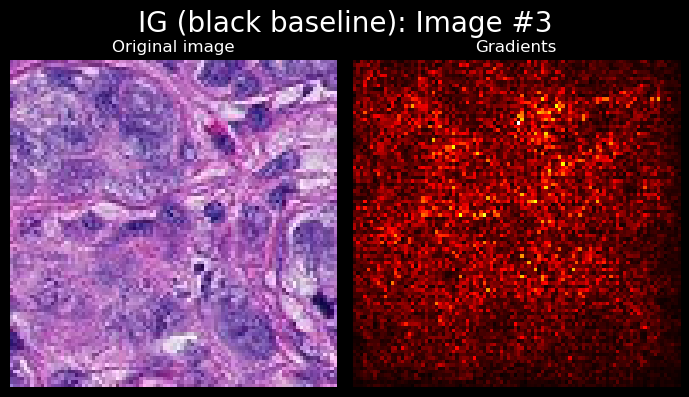

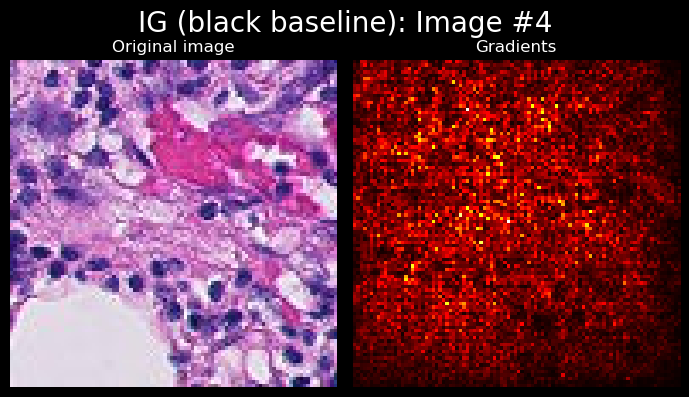

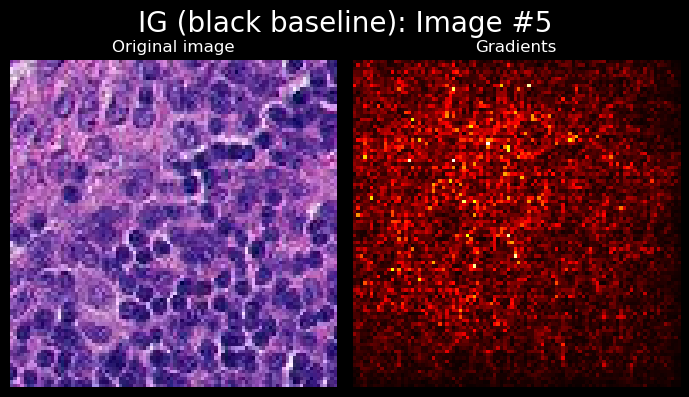

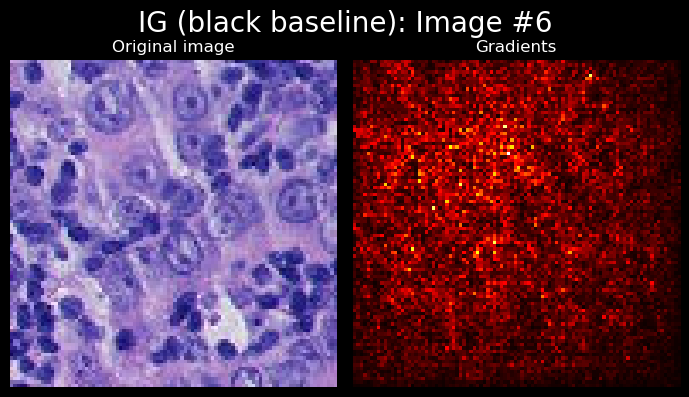

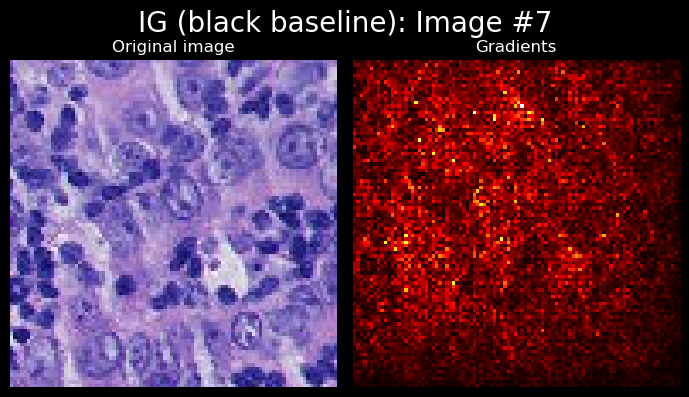

In [13]:
for ex, img, gradient in zip(examples, images, gradients_black):
    plot_gradients(img, gradient, title=f"IG (black baseline): {ex}")